## Causal Forest

## 1. How the tree was built?

In [118]:
#pip install econml
import random
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import econml
# Main imports
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso, WeightedLassoCV
from sklearn.linear_model import MultiTaskLassoCV
# Helper imports
from itertools import product
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from econml.grf import RegressionForest
%matplotlib inline
import patsy
import seaborn as sns

random.seed(1)

In [120]:
data_all = pd.read_csv("synthetic_data.csv")
data_all["schoolid"] = pd.Categorical(data_all["schoolid"])
data_all

,schoolid,Z,Y,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,76,1,0.081602,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,-0.385869,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,0.398184,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,-0.175037,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,0.884583,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10386,1,0,0.423366,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10387,1,0,-0.197092,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10388,1,0,0.141698,2,15,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10389,1,0,-0.351565,5,4,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702


In [122]:
DF = data_all.iloc[:,1:]
school_id = pd.to_numeric(data_all["schoolid"])
school_mat = np.zeros([data_all.shape[0],max(school_id)])

for i in range(data_all.shape[0]):
    school_mat[i,data_all["schoolid"][i]-1] = 1
    
school_size = school_mat.sum(axis=0)

In [126]:
data_all3= data_all.drop(['Y'], axis=1)
data_all3

,schoolid,Z,S3,C1,C2,C3,XC,X1,X2,X3,X4,X5
0,76,1,6,4,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
1,76,1,4,12,2,1,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
2,76,1,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
3,76,1,6,4,2,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
4,76,1,6,4,1,0,4,0.334544,0.648586,-1.310927,0.224077,-0.426757
...,...,...,...,...,...,...,...,...,...,...,...,...
10386,1,0,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10387,1,0,7,4,2,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10388,1,0,2,15,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702
10389,1,0,5,4,1,1,3,1.185986,-1.129889,1.009875,1.005063,-1.174702


In [128]:
formula = 'Z ~ schoolid + S3+ C1+ C2+ C3+ XC+ X1+ X2+ X3+ X4+ X5'

In [130]:
model = smf.glm(formula = formula, data=data_all3, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Z   No. Observations:                10391
Model:                            GLM   Df Residuals:                    10311
Model Family:                Binomial   Df Model:                           79
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6504.4
Date:                Thu, 06 Jun 2024   Deviance:                       13009.
Time:                        14:39:36   Pearson chi2:                 1.04e+04
No. Iterations:                   100   Pseudo R-squ. (CS):            0.01016
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.0478      0.140     -7.

* Grow a forest. Add extra trees for the causal forest.

In [135]:
W = DF["Z"]
Y = data_all["Z"]
X_raw = DF.iloc[:,2:]

In [137]:
X_raw.columns

Index(['S3', 'C1', 'C2', 'C3', 'XC', 'X1', 'X2', 'X3', 'X4', 'X5'], dtype='object')

In [139]:
C1_exp = pd.get_dummies(DF["C1"],prefix = "C1")
XC_exp = pd.get_dummies(DF["XC"],prefix = "XC")

In [141]:
X = pd.concat([X_raw.drop(columns=["C1","XC"]),C1_exp,XC_exp],axis=1)

In [143]:
X.columns

Index(['S3', 'C2', 'C3', 'X1', 'X2', 'X3', 'X4', 'X5', 'C1_1', 'C1_2', 'C1_3',
       'C1_4', 'C1_5', 'C1_6', 'C1_7', 'C1_8', 'C1_9', 'C1_10', 'C1_11',
       'C1_12', 'C1_13', 'C1_14', 'C1_15', 'XC_0', 'XC_1', 'XC_2', 'XC_3',
       'XC_4'],
      dtype='object')

In [151]:
# Preparing data to fit a causal forest
fmla = 'schoolid + S3+ C1+ C2+ C3+ XC+ X1+ X2+ X3+ X4+ X5'
desc = patsy.ModelDesc.from_formula(fmla)
desc.describe()
matrix = patsy.dmatrix(fmla, data_all, return_type = "dataframe")

W = DF["Z"] #treatment
#Y = data_all["Z"] #post-treatment
Y = DF['Y']
#X_raw = DF.iloc[:,2:]
X = matrix
W_n = None

# Estimate a causal forest.
est2 = CausalForestDML(model_t=RegressionForest(),
                       model_y=RegressionForest(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)

est2.tune(Y, W, X=X, W=W_n)
est2.fit(Y, W, X=X, W=W_n)

In [153]:
# Get residuals  and propensity 
residuals = est2.fit(Y, W, X=X, W=W_n, cache_values=True).residuals_
W_res = residuals[1]
e_hat = W - W_res 

In [154]:
Prop = pd.DataFrame({"p_score":e_hat, "Treatment":W})

In [155]:
tau_hat = est2.effect(X=X) # tau(X) estimates

In [156]:
tau_hat

array([0.27387535, 0.24592375, 0.25906053, ..., 0.19462195, 0.19472672,
       0.18980818])

In [315]:
from econml.dml import CausalForestDML
tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=2)
tree_model = tree_model.fit(Y=df.Y, X=df[X], T=df.D)

NameError: name 'df' is not defined

In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, df[X])
intrp.plot(feature_names=X, fontsize=12)

In [161]:
est2.feature_importances()

array([0.00000000e+00, 1.61245189e-04, 0.00000000e+00, 1.96229324e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.72255634e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.18442318e-03, 0.00000000e+00, 0.00000000e+00, 3.06974587e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.48286137e-04, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [163]:
importance = pd.DataFrame({"covariaties" : list(X.columns), "values" : est2.feature_importances()})

In [165]:
importance.sort_values('values', ascending = False)

,covariaties,values
81,X1,0.231752
85,X5,0.180997
82,X2,0.135045
77,C1,0.117726
84,X4,0.086707
...,...,...
30,schoolid[T.31],0.000000
29,schoolid[T.30],0.000000
28,schoolid[T.29],0.000000
26,schoolid[T.27],0.000000


Data-driven subgroup

In [167]:
#fmla = 'schoolid + S3+ C1+ C2+ C3+ XC+ X1+ X2+ X3+ X4+ X5'
fmla = '0+ schoolid + S3+ C1+ C2+ C3+ XC+ X1+ X2+ X3+ X4+ X5'
desc = patsy.ModelDesc.from_formula(fmla)
desc.describe()
matrix = patsy.dmatrix(fmla, data_all, return_type = "dataframe")

W = DF["Z"] #treatment
#Y = data_all["Z"] #post-treatment
Y = DF["Y"] #post-treatment
#X_raw = DF.iloc[:,2:]
W_n = None


In [249]:
def cluster_causal_forest(Y,T, X, W,  cluster):        
        
        base = pd.concat([Y,T], axis = 1)
        
        for i in range(cluster):
        
            index=range(X.shape[0]) 
            a = np.array_split(np.array(index),cluster)[i]  ## split index
            
            Y = base.drop(base.iloc[list(a),:].index).iloc[:,0]
            T = base.drop(base.iloc[list(a),:].index).iloc[:,1]
            XX = X.drop(X.iloc[list(a),:].index)
            causal = CausalForestDML(model_t=RegressionForest(),
                       model_y=RegressionForest(),
                       n_estimators=200, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)
            causal.fit(Y, T, X=XX, W=W)
            
            tau_hat = causal.effect(X=X.iloc[list(a),:]) # tau(X) estimates using validation data
            vector = i*np.ones( len(list(a)) ) + 1
            globals()[f'data_{i}'] = pd.DataFrame({"tau_hat":tau_hat, "Cluster":vector})
       
        tau_predict = data_0.copy()

        for k in range(1,10):
            tau_predict = tau_predict.concat(globals()[f'data_{k}'] , ignore_index=True)
        
        return tau_predict

In [253]:
num_folds = 10
num_rankings = 5  

In [290]:
tau_hat_cluster = cluster_causal_forest(Y,W, X, W_n,  cluster = num_folds)

data_all['ranking'] = np.nan

for i in range(1,num_folds+1):
    split = tau_hat_cluster.Cluster == i
    index = tau_hat_cluster[split].index
    tau_quantile = np.quantile(tau_hat_cluster[split].iloc[:,0], list(np.arange(0,1.1,0.2)))
    labels =[i for i in range(1,6)]
    data.loc[index , ["ranking"]] = pd.cut(tau_hat_cluster[split]["tau_hat"], 
                                               tau_quantile , right=False, labels=labels)

AttributeError: 'DataFrame' object has no attribute 'concat'

## 2. Estimate ATE

In [230]:
ATE = est2.effect(X)
# Calcular el intervalo de confianza del 95% para el ATE
ci_lower = ATE[1] - norm.ppf(0.975) * ATE[2]
ci_upper = ATE[1] + norm.ppf(0.975) * ATE[2]

# Imprimir el resultado
print("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(norm.ppf(0.975) * ATE[2], 3))

95% CI for the ATE: 0.226 +/- 0.485


With the tuned parameters, we estimate the average treatment effect (ATE) that is 0.226 and has a confidence interval (+/-0.0485) with a 95/% confidence. This means that the effect of the treatment or the intervetion related to the growth mind set had a positive and significant impact on the measure of achievement of the students on average.

## 3. Run best linear predictor analysis

In [236]:
tau_hat = est2.effect(X=X)

In [238]:
# Computing AIPW scores.
tau_hat = est2.effect(X=X) #E[Y|X]

residuals = est2.fit(Y, W, X=X, W=W_n, cache_values=True).residuals_
W_res = residuals[1]
e_hat = W - W_res  # P[W=1|X]

Y_res = residuals[0]
m_hat = Y - Y_res # E[Y|X]

mu_hat0 = m_hat - e_hat * tau_hat        # E[Y|X,W=0] = E[Y|X] - e(X)*tau(X)
mu_hat1 = m_hat + (1 - e_hat) * tau_hat  # E[Y|X,W=1] = E[Y|X] + (1 - e(X))*tau(X)

# AIPW scores
data_all['aipw_scores'] = tau_hat + W / e_hat * (Y -  mu_hat1) - (1 - W) / (1 - e_hat) * (Y -  mu_hat0)

In [239]:
d=data_all

In [240]:
d['m_hat'] = m_hat

In [241]:
smf.ols('m_hat ~ schoolid + S3+ C1+ C2+ C3+ XC+ X1+ X2+ X3+ X4+ X5',d).fit(cov_type = 'HC3').summary2().tables[1]

covariance of constraints does not have full rank. The number of constraints is 85, but rank is 80


,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-1.164420,0.016119,-72.236890,0.000000e+00,-1.196014,-1.132827
schoolid[T.2],0.059962,0.011997,4.997993,5.793009e-07,0.036448,0.083477
schoolid[T.3],0.092527,0.009995,9.257676,2.089294e-20,0.072938,0.112116
schoolid[T.4],-0.019255,0.010842,-1.775899,7.574956e-02,-0.040506,0.001996
schoolid[T.5],0.024309,0.013992,1.737416,8.231375e-02,-0.003114,0.051732
...,...,...,...,...,...,...
X1,-0.066211,0.003840,-17.241730,1.291148e-66,-0.073737,-0.058684
X2,-0.030225,0.003215,-9.400628,5.423859e-21,-0.036526,-0.023923
X3,0.027256,0.004857,5.611318,2.007910e-08,0.017736,0.036776
X4,0.002308,0.002809,0.821678,4.112604e-01,-0.003198,0.007814


It finds that if we insists in cluster-robust inference, there's almost no treatment heterogenity present and thus that the causal forest couldn't identify subgroups with effects at stand.

Due to this, they try to found if there's heterogenity between two specific variables: pre-existing mindset and school-level achievement. They find that schools with larger values of pre-existing mindset have larger effects than schools with smaller values of this variables. However, they do not see much heterogeneity along school-level achievement.

##  4. Look at school-wise heterogeneity

As seen before, there's much perceivable heterogenety at school-level. In order to see if this help us to identify heteregenous effects, we fit models using only school-level covariates. This fact seems to be presented on the next graphs, where the distribution of the school treatment effects and the student expectation success propensity score are shown

In [302]:
school_score = school_mat / school_size

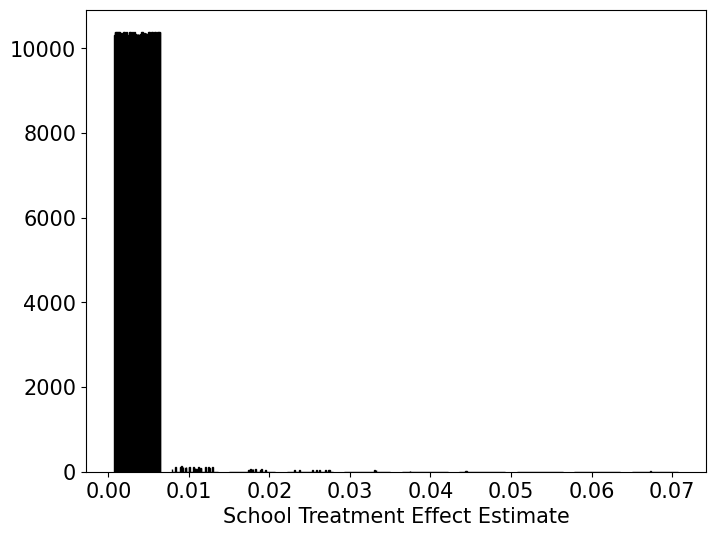

In [306]:
plt.figure(figsize=(8, 6))  # Configura el tamaño de la figura
plt.rcParams.update({'axes.labelsize': 15, 'xtick.labelsize': 15, 'ytick.labelsize': 15, 'axes.titlesize': 15})

# Crear el histograma
plt.hist(school_score, bins=10, edgecolor='black')

# Etiquetas y título
plt.xlabel('School Treatment Effect Estimate')
plt.title('')

# Mostrar el gráfico
plt.show()

## 5. Analysis ignoring clusters. How do the results change?

We have seen until now no evidence on heteregenious effects of the treatment considering clusters. This mean we have token into account the possible correlation between students that attend the same school. Althought it will be naive to be believed that this doesn't happend, it will helpful to analyse whether there exist consistent difference

In [311]:
estimator = CausalForestDML(model_t=RandomForestRegressor(),
                            model_y=RandomForestRegressor(),
                            discrete_treatment=True,
                            n_estimators=100)


estimator.fit(Y, W, X=X)


ATE_noclust = estimator.ate(X)
ATE_mean = ATE_noclust[0]
ATE_ci = norm.ppf(0.975) * ATE_noclust[1]

print(f"95% CI for the ATE: {ATE_mean:.3f} +/- {ATE_ci:.3f}")
tau_hat_noclust = estimator.effect(X)

plt.scatter(school_id, tau_hat_noclust)
plt.xlabel("School ID")
plt.ylabel("Tau Hat (No Clustering)")
plt.show()

nfold = 5
school_levels = np.unique(school_id)
cluster_folds = np.random.randint(1, nfold + 1, size=len(school_levels))

tau_hat_crossfold = np.full(len(Y), np.nan)
for foldid in range(1, nfold + 1):
    print(foldid)
    infold = np.isin(school_id, school_levels[cluster_folds == foldid])
    
    X_train, X_test = X[~infold], X[infold]
    Y_train, Y_test = Y[~infold], Y[infold]
    W_train, W_test = W[~infold], W[infold]
    Y_hat_train, W_hat_train = Y_hat[~infold], W_hat[~infold]
    
    estimator_fold = C

AssertionError: Dimension mismatch

## 6. Analysis without fitting the propensity score

We see that propensity score is not as important to the results found as clsutering was since it appers to be that the ATE found (0.254) is very much similar to the one found using orthogalization. As we can see in the followin figure, the overlaped distribution are almost the same because they are really close to the 45 degree line that means equiality between the two variables (that are the estimates).

In [ ]:
cf_noprop = CausalForestDML(model_t=RandomForestRegressor(),
                            model_y=RandomForestRegressor(),
                            discrete_treatment=True,
                            n_estimators=100,
                            equalize_cluster_weights=True,
                            clusters=school_id)

cf_noprop.fit(Y, W, X=X, W_hat=np.mean(W), Y_hat=Y_hat)


ATE_noprop = cf_noprop.ate(X)
ATE_mean_noprop = ATE_noprop[0]
ATE_ci_noprop = norm.ppf(0.975) * ATE_noprop[1]

print(f"95% CI for the ATE (noprop): {ATE_mean_noprop:.3f} +/- {ATE_ci_noprop:.3f}")


tau_hat_noprop = cf_noprop.effect(X)


plt.figure(figsize=(8, 6))
plt.scatter(tau_hat, tau_hat_noprop)
plt.xlim(min(tau_hat), max(tau_hat))
plt.ylim(min(tau_hat), max(tau_hat))
plt.xlabel("orthogonalized causal forest estimates")
plt.ylabel("non-orthogonalized causal forest")
plt.plot([min(tau_hat), max(tau_hat)], [min(tau_hat), max(tau_hat)], linestyle="--", linewidth=2, color="r")
plt.show()


school_X = np.dot(np.transpose(school.mat), X[:, [3, 4, 5, 6, 7, 24, 25, 26, 27, 28]]) / school.size
school_X = pd.DataFrame(school_X, columns=["X1", "X2", "X3", "X4", "X5", "XC.1", "XC.2", "XC.3", "XC.4"])

dr_score = tau_hat + W / cf.W_hat * (Y - cf.Y_hat - (1 - cf.W_hat) * tau_hat) - (1 - W) / (1 - cf.W_hat) * (Y - cf.Y_hat + cf.W_hat * tau_hat)
school_score = np.dot(np.transpose(school.mat), dr_score) / school.size

school_forest = RandomForestRegressor()
school_forest.fit(school_X, school_score)
school_pred = school_forest.predict(school_X)


school_DF = pd.concat([school_X, pd.Series(school_score, name='school_score')], axis=1)
ols_model = sm.OLS(school_score, sm.add_constant(school_X)).fit()
ols_results = ols_model.summary()

print(ols_results)

## 7. The code plot six plots in the Make some plots section, so explain what you find there

In [ ]:

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12


plt.hist(tau_hat, bins=20, edgecolor='black')
plt.xlabel("estimated CATE")
plt.ylabel("Frequency")
plt.title("Histogram of tau.hat")
plt.show()


plt.hist(tau_hat_noprop, bins=20, edgecolor='black')
plt.xlabel("estimated CATE")
plt.ylabel("Frequency")
plt.title("Histogram of tau.hat.noprop")
plt.show()


plt.hist(tau_hat_noclust, bins=np.arange(-0.0, 0.55, 0.55/25), edgecolor='black')
plt.xlabel("estimated CATE")
plt.ylabel("Frequency")
plt.title("Histogram of tau.hat.noclust")
plt.show()


plt.boxplot([tau_hat[X[:, 0] == i] for i in np.unique(X[:, 0].round())], labels=np.unique(X[:, 0].round()))
plt.xlabel("X1")
plt.ylabel("estimated CATE")
plt.title("Boxplot of tau.hat by X1")
plt.show()


plt.boxplot([tau_hat[X[:, 1] == i] for i in np.unique(X[:, 1].round())], labels=np.unique(X[:, 1].round()))
plt.xlabel("X2")
plt.ylabel("estimated CATE")
plt.title("Boxplot of tau.hat by X2")
plt.show()


plt.scatter(school.avg.tauhat, school.pred, c='blue', s=50)
plt.plot(school.avg.tauhat, school.avg.tauhat, linestyle='--', color='red', linewidth=2)
plt.xlabel("average CATE estimate in school")
plt.ylabel("school-wise forest predictions")
plt.title("Scatter plot of school.avg.tauhat vs. school.pred")
plt.show()


n_synth = 1000
p_synth = 10
X_synth = np.random.normal(size=(n_synth, p_synth))
W_synth = np.random.binomial(1, 1 / (1 + np.exp(-X_synth[:, 0])), size=n_synth)
Y_synth = 2 * np.mean(X_synth[:, :6], axis=1) + np.random.normal(size=n_synth)

Y_forest_synth = RandomForestRegressor().fit(X_synth, Y_synth)
Y_hat_synth = Y_forest_synth.predict(X_synth)
W_forest_synth = RandomForestRegressor().fit(X_synth, W_synth)
W_hat_synth = W_forest_synth.predict(X_synth)

cf_synth = CausalForestDML(model_t=RandomForestRegressor(), model_y=RandomForestRegressor())
cf_synth.fit(Y_synth, W_synth, X_synth, W_hat=W_hat_synth, Y_hat=Y_hat_synth)
ATE_synth = cf_synth.ate(X_synth)

cf_synth_noprop = CausalForestDML(model_t=RandomForestRegressor(), model_y=RandomForestRegressor())
cf_synth_noprop.fit(Y_synth, W_synth, X_synth, W_hat=np.mean(W_synth), Y_hat=Y_hat_synth)
ATE_synth_noprop = cf_synth_noprop.ate(X_synth)

print(f"95% CI for the ATE (synth): {round(ATE_synth[0], 3)} +/- {round(norm.ppf(0.975) * ATE_synth[1], 3)}")
print(f"95% CI for the ATE (synth noprop): {round(ATE_synth_noprop[0], 3)} +/- {round(norm.ppf(0.975) * ATE_synth_noprop[1], 3)}")


## 8. Visualize school-level covariates by treatment heterogeneity

In [ ]:
scaler = StandardScaler()
school.X_std = scaler.fit_transform(school.X)


terciles = pd.cut(school.pred, bins=[-np.inf, school.pred.quantile(1/3), school.pred.quantile(2/3), np.inf],
                  labels=["low", "mid", "high"])
school.tercile_mat = pd.get_dummies(terciles).values


means = np.linalg.pinv(np.sum(school.tercile_mat, axis=0) * np.eye(school.tercile_mat.shape[1])) @ \
        school.tercile_mat.T @ school.X_std


df_plot = pd.DataFrame({"tercile": np.repeat(["low", "mid", "high"], school.tercile_mat.shape[1]),
                        "mean": means.flatten(),
                        "feature": np.tile(school.X.columns, 3)})

plt.figure(figsize=(10, 6))
sns.heatmap(df_plot.pivot("tercile", "feature", "mean"), cmap="coolwarm", annot=True, fmt=".2f")
plt.savefig("tercile_plot.pdf")


mean_XC_3 = np.mean(school.X["XC.3"])
mean_XC_3_low_tercile = np.mean(school.X["XC.3"][terciles == "low"])

This graph show us the difference between the mean of the CATE for each school-level covariate considered in the school-wise estimation. We can see that there is not much hetereginty between the means in all covariates but the X1, where the difference between the low and high group of CATEs. This reminds us that even if it seem to be variability in the effects when we divide by this covariate, there's not enough evidence that controling with the other covariates this effect will remain even when analysing the data at school-level.

## 9. CATE by school

In [ ]:
ord_indices = np.argsort(np.argsort(school.pred))
school_sort = ord_indices[school.id]

plt.figure(figsize=(12, 6))
plt.boxplot(tau_hat_noclust, positions=school_sort, widths=0.5)
plt.scatter(range(1, 77), np.sort(school.pred), color='red', marker='o', label='school mean CATE')
plt.xlabel("school")
plt.ylabel("estimated CATE")
plt.legend(loc="upper left")
plt.savefig("school_boxplot.pdf")
plt.show()


This graph compares per-student predictions from a non-cluster-robust causal forest to per-school mean treatment effect predictions from a forest trained on per-school responses that takes clustering into account. As seen before. We can see that CATE found in when ignoring clusters is higher and more disperse by school than when considering clusters.